In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

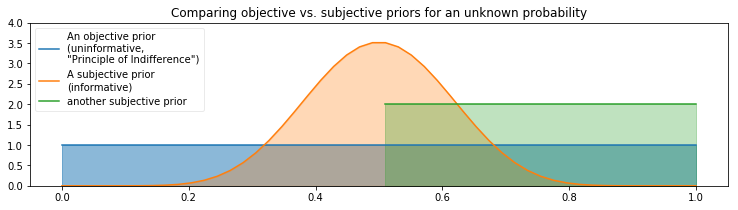

In [2]:
figsize(12.5, 3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,  label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha=0.3)
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x, y2, label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x[25:], 2*np.ones(25), label="another subjective prior")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha=0.3)

plt.ylim(0,4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability")